In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #disable tensorflow warnings

In [3]:

def read_from_source():
    df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
    df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
    df['Date'] = pd.to_datetime(df['Date'])
    return df



def pred_covid(model_name, df, model_idx): #GRU or LSTM
    #model = load_model('../'+model_name +'_infected_only_GRU_LSTM_Oct16.h5') #best
    model = load_model('LSTM_GRU_Oct23_relu/' + model_name +'_infected_only_Oct23_'+str(model_idx)+'.h5')
    print(model_name,'loaded')

    #constant
    n_steps_in = 14
    n_steps_out = 4
    sc = MinMaxScaler(feature_range = (0, 1))
    
    x_input = df['Infected'][-n_steps_in:].values # last 14 day
    x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
    x_input = x_input.reshape((1, n_steps_in, 1))
    
    #y_pred = model.predict(x_input) # too much warnings
    y_pred = model(x_input)
    y_pred = sc.inverse_transform(y_pred) #revert scaling
    #print('Next 4 days prediction:', y_pred)
    
    start_date = str(df['Date'].iloc[-14])[:10]
    end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
    end_date = str(end_date)[:10]
    #print(start_date,'---', end_date)
    time_range = pd.date_range(start=start_date, end=end_date)
    
    pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred[0,:]))
    return pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

In [4]:
df = read_from_source()
df

,Date,Infected
0,2020-01-16,1.0
1,2020-01-17,0.0
2,2020-01-18,0.0
3,2020-01-19,0.0
4,2020-01-20,0.0
...,...,...
649,2021-10-26,309.0
650,2021-10-27,310.0
651,2021-10-28,268.0
652,2021-10-29,291.0


In [5]:
df[-14:]

,Date,Infected
640,2021-10-17,425.0
641,2021-10-18,223.0
642,2021-10-19,367.0
643,2021-10-20,387.0
644,2021-10-21,334.0
645,2021-10-22,324.0
646,2021-10-23,277.0
647,2021-10-24,229.0
648,2021-10-25,147.0
649,2021-10-26,309.0


In [6]:
pred_covid('LSTM', df,3)

LSTM loaded


,Date,Predict Infected
0,2021-10-31,221.455998
1,2021-11-01,211.583530
2,2021-11-02,216.445708
3,2021-11-03,220.885126


In [7]:
def get_prediction(model, df): #model = 'GRU' or 'LSTM'
    pred_arr = []
    for model_idx in [1,2,3]:
        #print(model,model_idx,pred_covid(model, df,model_idx))
        pred_arr.append(np.array(pred_covid(model, df,model_idx)['Predict Infected'].values))
    return np.array(pred_arr)

In [8]:
def get_PI(pred_arr):
    intervals = []
    means = []
    uppers = []
    lowers = []
    for idx in [0,1,2,3]:
        cov_std = pred_arr[:,idx].std()
        cov_interval = cov_std*1.96
        cov_mean = pred_arr[:,idx].mean()
        cov_lower = cov_mean - cov_interval
        cov_upper = cov_mean + cov_interval
        print(pred_arr[:,idx], 'Interval: ',cov_interval , 'Upper: ',cov_lower, 'Mean: ',cov_mean, 'Upper: ',cov_upper)
        
        intervals.append(int(cov_interval))
        means.append(int(cov_mean))
        uppers.append(int(cov_upper))
        lowers.append(int(cov_lower))
    
    return intervals, means, uppers, lowers

In [9]:
%%time
GRU_pred_arr = get_prediction('GRU',df)
cov_intervals, cov_means, cov_uppers, cov_lowers = get_PI(GRU_pred_arr)


GRU loaded
GRU loaded
GRU loaded
[258.92476916 271.7638641  233.60713619] Interval:  31.071208938024597 Upper:  223.69404754632498 Mean:  254.76525648434958 Upper:  285.8364654223742
[231.51855075 249.67377007 253.4188841 ] Interval:  18.74579981870768 Upper:  226.1246018220254 Mean:  244.8704016407331 Upper:  263.6162014594408
[256.39438367 312.22037983 260.80186224] Interval:  49.66980004348887 Upper:  226.80240853589243 Mean:  276.4722085793813 Upper:  326.14200862287015
[232.10438633 316.68577087 275.56890386] Interval:  67.6878925336842 Upper:  207.09846115376115 Mean:  274.78635368744534 Upper:  342.47424622112953
Wall time: 4.75 s


In [10]:
GRU_pred_arr

array([[258.92476916, 231.51855075, 256.39438367, 232.10438633],
       [271.7638641 , 249.67377007, 312.22037983, 316.68577087],
       [233.60713619, 253.4188841 , 260.80186224, 275.56890386]])

In [11]:
cov_means

[254, 244, 276, 274]

In [12]:
y = cov_means


In [13]:
start_date = str(df[-14:]['Date'].iloc[0])[:10]
start_date

'2021-10-17'

In [14]:
end_date = pred_covid('GRU', df,3)['Date'][3]
end_date

GRU loaded


'2021-11-03'

In [15]:
time_range = pd.date_range(start = start_date, end= end_date)


In [16]:
time_range[:-4]

DatetimeIndex(['2021-10-17', '2021-10-18', '2021-10-19', '2021-10-20',
               '2021-10-21', '2021-10-22', '2021-10-23', '2021-10-24',
               '2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28',
               '2021-10-29', '2021-10-30'],
              dtype='datetime64[ns]', freq='D')

In [17]:
len(time_range)

18

In [18]:
cov_intervals

[31, 18, 49, 67]

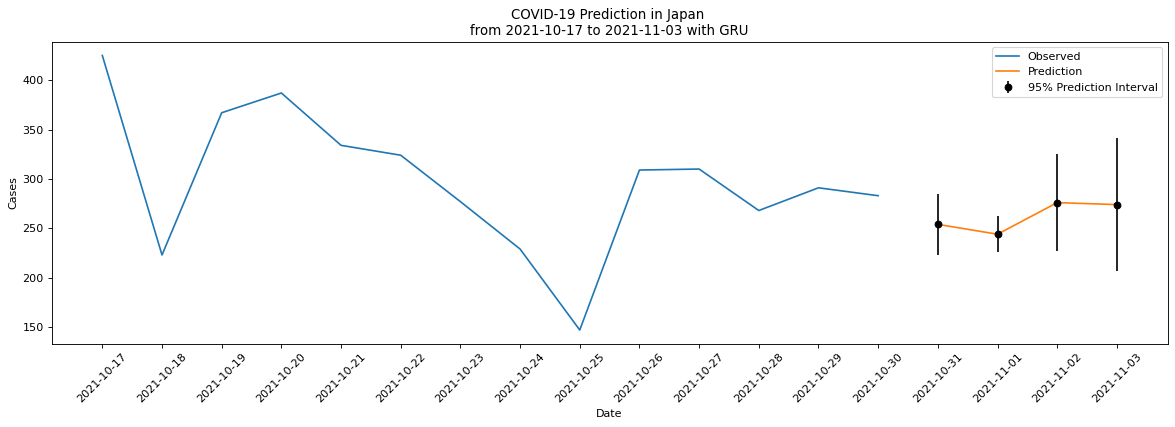

In [19]:
from matplotlib.pyplot import figure
figure(figsize=(18, 5), dpi=80)

plt.plot(time_range[:-4],df['Infected'][-14:], label='Observed')
plt.plot(time_range[-4:],y, label='Prediction')

plt.errorbar(time_range[-4], y[0], yerr=cov_intervals[0] , color='black', fmt='o', label='95% Prediction Interval')
plt.errorbar(time_range[-3], y[1], yerr=cov_intervals[1] , color='black', fmt='o')
plt.errorbar(time_range[-2], y[2], yerr=cov_intervals[2], color='black', fmt='o')
plt.errorbar(time_range[-1], y[3], yerr=cov_intervals[3], color='black', fmt='o')

plt.xlabel('Date')
plt.ylabel('Cases')
plt.xticks(time_range,rotation=45)
plt.title('COVID-19 Prediction in Japan \nfrom {0} to {1} with GRU'.format(start_date, end_date))
plt.legend()
plt.show()

### Read data from source

In [20]:
df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)
print(df.shape)
df.tail()

Date        datetime64[ns]
Infected           float64
dtype: object
(654, 2)


,Date,Infected
649,2021-10-26,309.0
650,2021-10-27,310.0
651,2021-10-28,268.0
652,2021-10-29,291.0
653,2021-10-30,283.0


### Load GRU

In [21]:
model_GRU = load_model('../GRU_infected_only_GRU_LSTM_Oct16.h5')
model_GRU

In [22]:
n_steps_in = 14
n_steps_out = 4

In [23]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))

In [24]:
x_input = df['Infected'][-n_steps_in:].values # last 14 day
x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
x_input = x_input.reshape((1, n_steps_in, 1))
print(x_input.shape)

(1, 14, 1)


In [25]:
y_pred_GRU = model_GRU.predict(x_input)
y_pred_GRU = sc.inverse_transform(y_pred_GRU) #revert scaling
print(y_pred_GRU)

[[267.01834 248.34499 246.20049 260.95575]]


In [26]:
x_input_raw = df['Infected'][-n_steps_in:].values
print(x_input_raw.reshape(n_steps_in))

[425. 223. 367. 387. 334. 324. 277. 229. 147. 309. 310. 268. 291. 283.]


### Range: 18 days

In [27]:
start_date = str(df['Date'].iloc[-14])[:10]

end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
end_date = str(end_date)[:10]

print(start_date,'---', end_date)

2021-10-17 --- 2021-11-03


In [28]:
time_range = pd.date_range(start=start_date, end=end_date)
print(time_range.shape)

(18,)


In [29]:
y_pred_GRU[0,:]

array([267.01834, 248.34499, 246.20049, 260.95575], dtype=float32)

In [30]:
pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred_GRU[0,:]))
pred_list

[('2021-10-31', 267.01834),
 ('2021-11-01', 248.34499),
 ('2021-11-02', 246.20049),
 ('2021-11-03', 260.95575)]

In [31]:
pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

,Date,Predict Infected
0,2021-10-31,267.018341
1,2021-11-01,248.344986
2,2021-11-02,246.200485
3,2021-11-03,260.955750


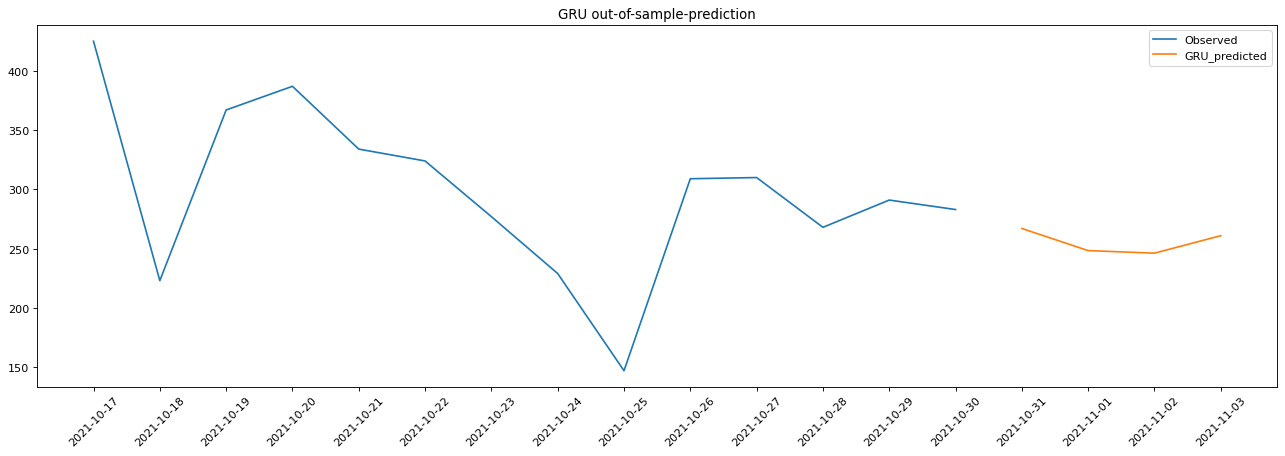

In [32]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.plot(time_range[:14],x_input_raw.reshape(n_steps_in), label='Observed')
plt.plot(time_range[14:], y_pred_GRU[0,:], label='GRU_predicted')
plt.title('GRU out-of-sample-prediction')
plt.xticks(time_range,rotation=45)
plt.legend()
plt.show()